# Important Libraries

In [1]:
! pip install SimpleITK
! pip install imutils
! pip install opencv-python
! pip install torch torchvision torchaudio
! pip install torchsummary
! pip install torchmetrics

In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils import plot_model

In [3]:
import SimpleITK as sitk
import numpy as np
import cv2
import os
import h5py
import re
import pandas as pd
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import torch
import torch.nn as nn
import torch.nn.functional as F
import imutils
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy
import torchmetrics
from tqdm import tqdm
import torch.optim as optim

In [5]:
import SimpleITK as sitk
import numpy as np
import cv2
import os
import h5py
import numpy as np
import re

In [6]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
if torch.cuda.is_available():
    print("CUDA is available. Number of GPUs: ", torch.cuda.device_count())
    print("Curent GPU: ", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Using CPU")

CUDA is available. Number of GPUs:  2
Curent GPU:  NVIDIA GeForce RTX 2080 SUPER


# Preprocessing

In [8]:
# Path to the directory containing H5 files
path = r"C:\Users\Data Science F24-MSF\Desktop\BraTS2020_training_data\content\data" # Ensure this path is correct

# Check if the directory exists
if not os.path.exists(path):
    raise FileNotFoundError(f"The directory {path} does not exist.")

# List all H5 files in the directory
file_names = [f for f in os.listdir(path) if f.endswith('.h5')]

# Sort files based on the numbers following 'volume' and 'slice'
def extract_volume_and_slice_key(file_name):
    volume_match = re.search(r'volume_(\d+)', file_name)
    slice_match = re.search(r'slice_(\d+)', file_name)
    volume_num = int(volume_match.group(1)) if volume_match else float('inf')
    slice_num = int(slice_match.group(1)) if slice_match else float('inf')
    return volume_num, slice_num

# Sort file names by volume number first, then slice number
file_names.sort(key=extract_volume_and_slice_key)

# Preallocate list for all patients
arr = []

# Loop through all 70 patients, loading their corresponding 155 slices
for patient_id in range(50):  # Looping over patients from 1 to 50
    patient_images = []

    # Collect 155 slices for the current patient, indexed from 0 to 154
    for slice_id in range(155):  # Slices are indexed from 0 to 154
        # Construct the filename
        file_name = f"volume_{patient_id}_slice_{slice_id}.h5"
        file_path = os.path.join(path, file_name)

        # Check if the file exists
        if os.path.isfile(file_path):
            # Open the H5 file
            with h5py.File(file_path, 'r') as h5_file:
                # Print the available datasets for debugging
                print(f"Exploring {file_name}...")
                datasets = list(h5_file.keys())  # Convert keys to a list to avoid multiple calls

                # Check if expected datasets exist
                if 'image' in datasets:  # Assuming 'image' holds the scan data
                    img_array = h5_file['image'][...]  # Load image data
                    patient_images.append(img_array)
                else:
                    print(f"Warning: 'image' dataset not found in {file_name}")
        else:
            print(f"Warning: {file_name} does not exist.")

    # Convert list of images for this patient to a 3D array
    if patient_images:
        patient_data = np.array(patient_images)
        arr.append(patient_data)  # Append to the main list for this patient

# Now 'arr' contains 3D arrays of image slices for each patient
# Example: arr[0] corresponds to the first patient with 155 slices
print(f"Loaded {len(arr)} patients with {len(arr[0]) if arr else 0} slices each.")


Exploring volume_1_slice_0.h5...
Exploring volume_1_slice_1.h5...
Exploring volume_1_slice_2.h5...
Exploring volume_1_slice_3.h5...
Exploring volume_1_slice_4.h5...
Exploring volume_1_slice_5.h5...
Exploring volume_1_slice_6.h5...
Exploring volume_1_slice_7.h5...
Exploring volume_1_slice_8.h5...
Exploring volume_1_slice_9.h5...
Exploring volume_1_slice_10.h5...
Exploring volume_1_slice_11.h5...
Exploring volume_1_slice_12.h5...
Exploring volume_1_slice_13.h5...
Exploring volume_1_slice_14.h5...
Exploring volume_1_slice_15.h5...
Exploring volume_1_slice_16.h5...
Exploring volume_1_slice_17.h5...
Exploring volume_1_slice_18.h5...
Exploring volume_1_slice_19.h5...
Exploring volume_1_slice_20.h5...
Exploring volume_1_slice_21.h5...
Exploring volume_1_slice_22.h5...
Exploring volume_1_slice_23.h5...
Exploring volume_1_slice_24.h5...
Exploring volume_1_slice_25.h5...
Exploring volume_1_slice_26.h5...
Exploring volume_1_slice_27.h5...
Exploring volume_1_slice_28.h5...
Exploring volume_1_slice

In [9]:
arr = np.array(arr)

# Output shapes for confirmation
print(f"Total Patients: {len(arr)+1}")
print(f"Shape of first patient's images: {arr[0].shape if len(arr) > 0 else 'No data'}")

Total Patients: 50
Shape of first patient's images: (155, 240, 240, 4)


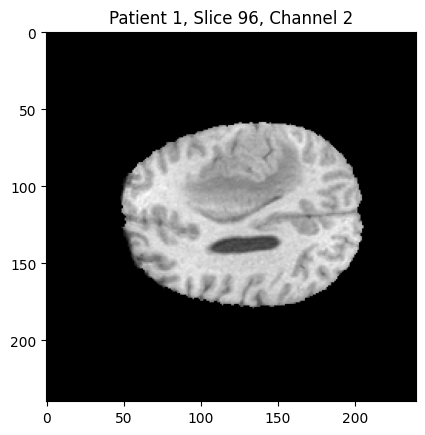

In [10]:
# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

import matplotlib.pyplot as plt

# Extract a 2D slice from the 4D array
# arr[patient_index][slice_index, :, :, channel_index]
img = arr[0][96, :, :, 1]  # Patient 0, slice 4, all height and width, channel 2

# Display the 2D image slice
plt.imshow(img, cmap='gray')  # Use cmap='gray' for grayscale display
plt.title('Patient 1, Slice 96, Channel 2')
plt.show()

Image shape: (240, 240)


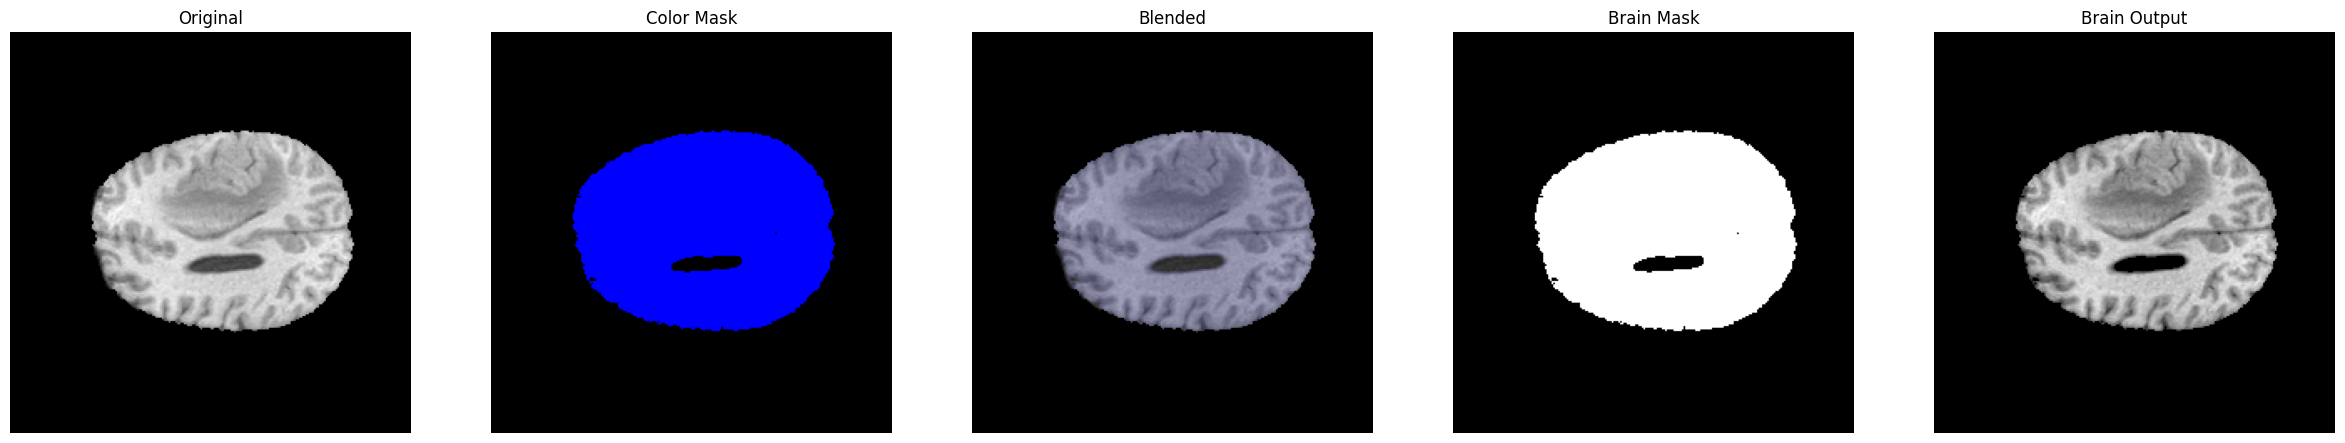

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Skull stripping
img = arr[0][96, :, :, 1]  # Selecting the first slice with one channel

# Check the shape of img
print(f"Image shape: {img.shape}")  # Should print (240, 240)

# Convert the image to 8-bit (0-255) if it's not already
img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Create a color mask based on the thresholded image
colormask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)  # Create a blank color mask
colormask[thresh != 0] = np.array((0, 0, 255))  # Red for the mask

# Blend the original image and the color mask
blended = cv2.addWeighted(cv2.cvtColor(img_8bit, cv2.COLOR_GRAY2BGR), 0.7, colormask, 0.1, 0)

# Connected components
ret, markers = cv2.connectedComponents(thresh)

# Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers == m) for m in range(1, np.max(markers) + 1)]  # Start from 1 to skip the background

# Get label of the largest component by area
largest_component = np.argmax(marker_area) + 1  # Add 1 since we dropped zero above

# Get pixels which correspond to the brain
brain_mask = markers == largest_component

brain_out = img.copy()

# In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[~brain_mask] = 0  # Set non-brain pixels to 0 (black)

# Visualize the results
image_list = [img_8bit, colormask, blended, (brain_mask.astype(np.uint8) * 255), brain_out]  # Convert boolean mask to uint8
image_label = ["Original", "Color Mask", "Blended", "Brain Mask", "Brain Output"]

plt.figure(figsize=(30, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)  # Adjusted to 1, 5 for correct subplot indexing
    plt.title(image_label[i])
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()

Shape of arr: (49, 155, 240, 240, 4)


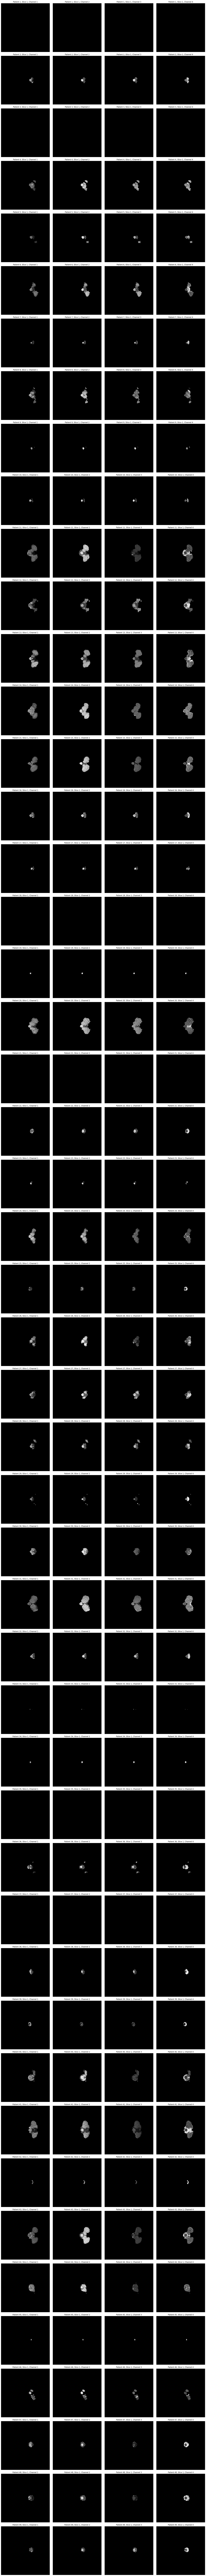

In [12]:
# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

import matplotlib.pyplot as plt

# Check the shape of the array to determine dimensions
print("Shape of arr:", arr.shape)

# Determine the number of patients and channels
num_patients = arr.shape[0]  # Total number of patients
num_slices = arr.shape[1]     # Total number of slices
num_channels = arr.shape[4]   # Total number of channels (assuming channel is the last dimension)

# Set up the figure for plotting
plt.figure(figsize=(20, num_patients * 5))  # Adjust the figure size as needed

# Loop over each patient and each channel
for patient_index in range(num_patients):
    for channel_index in range(num_channels):
        # Extract the 2D slice for each patient and channel
        # Assuming you want to display the first slice (index 0)
        if num_slices > 0:  # Ensure there is at least one slice
            img = arr[patient_index][3, :, :, channel_index]
            ''' Assuming you want to display slice 1 '''
        else:
            print(f"No slices available for patient {patient_index}.")
            continue  # Skip this iteration if no slices are available

        # Calculate subplot index
        plt.subplot(num_patients, num_channels, patient_index * num_channels + channel_index + 1)
        plt.imshow(img, cmap='gray')  # Use cmap='gray' for grayscale display
        plt.title(f'Patient {patient_index + 1}, Slice 1, Channel {channel_index + 1}')  # Titles are 1-based
        plt.axis('off')  # Turn off axis labels

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [13]:
def apply_stripping(image_list):
    stripped_images = []

    for i in range(len(image_list)):
        img = image_list[i]

        # Check the shape of the image
        if img.ndim == 4:
            gray = img[3, :, :, 0]
        elif img.ndim == 3:
            gray = img
        else:
            print(f"Unexpected image shape for image {i}: {img.shape}")
            continue

        # Normalize to uint8
        if gray.dtype != np.uint8:
            gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Apply Gaussian Blur to reduce noise
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Manual or Adaptive Thresholding
        ret, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)  # Manual thresholding
        # Or use adaptive thresholding
        # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

        if np.count_nonzero(thresh) == 0:
            print(f"No features found in image {i} after thresholding.")
            continue

        colormask = np.zeros((img.shape[1], img.shape[2], 3), dtype=np.uint8)
        colormask[thresh != 0] = np.array((0, 0, 255))

        blended = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 0.7, colormask, 0.1, 0)

        ret, markers = cv2.connectedComponents(thresh)

        if ret <= 1:
            print(f"No components found in image {i}.")
            continue

        marker_area = [np.sum(markers == m) for m in range(1, np.max(markers) + 1)]

        if len(marker_area) == 0:
            print(f"No markers found for image {i}.")
            continue

        largest_component = np.argmax(marker_area) + 1
        brain_mask = markers == largest_component

        brain_out = img[0, :, :, :].copy()
        brain_out[~brain_mask] = 0

        stripped_images.append((gray, colormask, blended, (brain_mask.astype(np.uint8) * 255), brain_out))

    return stripped_images

In [14]:
stripped_images=apply_stripping(arr)

No features found in image 0 after thresholding.
No features found in image 2 after thresholding.
No features found in image 4 after thresholding.
No features found in image 17 after thresholding.
No features found in image 20 after thresholding.
No features found in image 30 after thresholding.
No features found in image 32 after thresholding.
No features found in image 34 after thresholding.
No features found in image 36 after thresholding.


In [15]:
import matplotlib.pyplot as plt

# Extract images for visualization
def visualize_stripped_images(stripped_images):
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    for i, images in enumerate(stripped_images):
        # Each 'images' is a tuple with (gray, colormask, blended, brain_mask, brain_out)
        for j, img in enumerate(images):
            plt.subplot(len(stripped_images), 5, i * 5 + j + 1)  # 5 images per row
            plt.title(f'Image {i+1}, Step {j+1}')
            plt.imshow(img, cmap='gray' if j == 0 else None)  # Use gray colormap for the first image
            plt.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03494350735547081..36.89467012731303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06844993332545087..17.394941158605995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07434190896104544..27.727952759321305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025869290404832414..0.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09994857693601367..19.953035740218215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013801552615900341..83.62814441364442].
Clipping input data to the vali

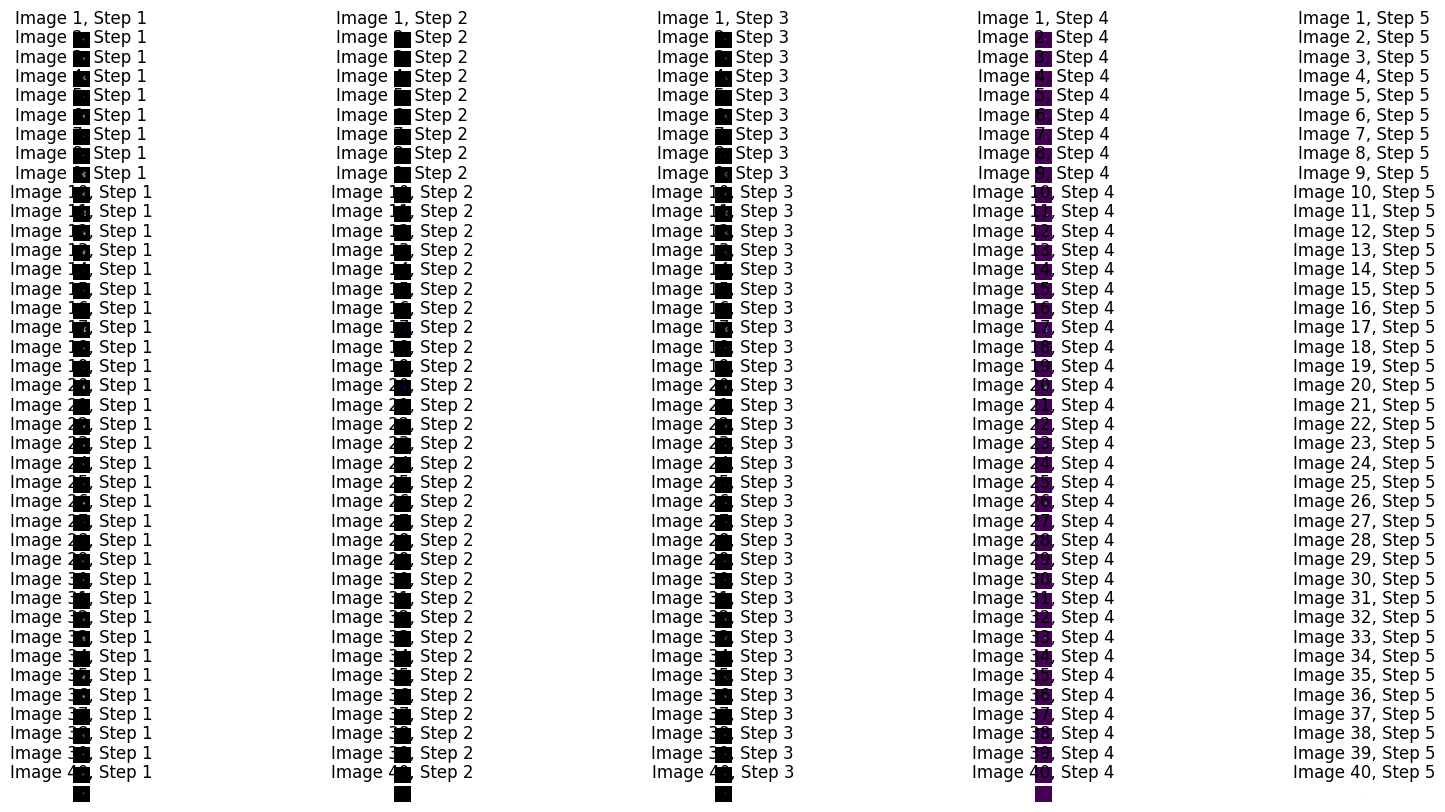

In [16]:
visualize_stripped_images(stripped_images)

In [17]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


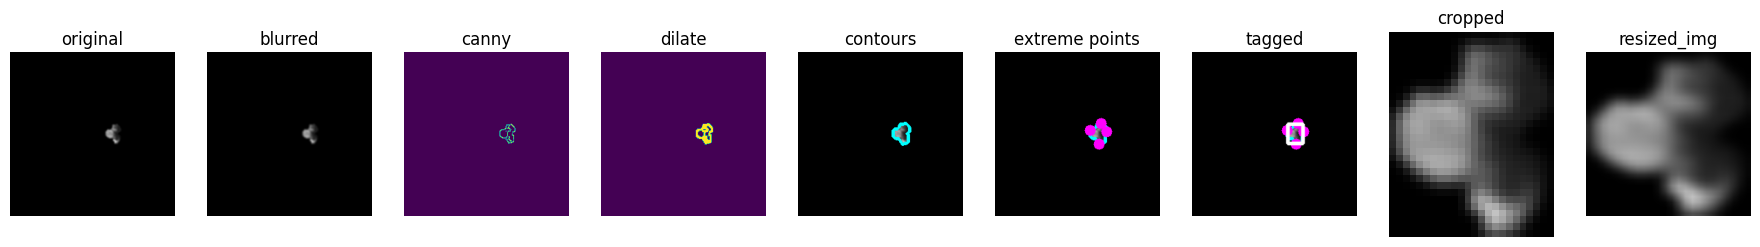

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

# Load the sample image
input_image=stripped_images[0][0]

# Data type conversion and normalization
if input_image.dtype != np.uint8:
    # Normalize the image based on its maximum value
    input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)

# Preprocessing: Gaussian blur on grayscale
blurred = cv2.GaussianBlur(input_image, (3, 3), 0)

# Apply Canny edge detection
canny = cv2.Canny(blurred, 30, 100)

# Define a (3, 3) structuring element and apply dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilate = cv2.dilate(canny, kernel, iterations=1)

# Convert grayscale image to 3-channel BGR after preprocessing
if len(input_image.shape) == 2 or input_image.shape[-1] == 1:
    input_image_colored = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
else:
    input_image_colored = input_image.copy()

# Convert blurred to BGR for consistent color output (since blurred is grayscale)
blurred_colored = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)

# Find the non-zero min-max coordinates of Canny
pts = np.argwhere(canny > 0)
y1, x1 = pts.min(axis=0)
y2, x2 = pts.max(axis=0)

# Find contours in the dilated image, then grab the largest one
cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# Find the extreme points in the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Draw contours on the image
img_cnt = cv2.drawContours(input_image_colored.copy(), [c], -1, (0, 255, 255), 4)

# Mark extreme points with colors
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (255, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (255, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 0, 255), -1)

# Draw rectangle around the brain region based on the extreme points
tagged = cv2.rectangle(img_pnt.copy(), (x1, y1), (x2, y2), (255, 255, 255), 3, cv2.LINE_AA)

# Crop the region of interest (ROI) based on extreme points
ADD_PIXELS = 0  # You can adjust this to add padding around the cropped area
cropped = input_image_colored[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# Resize the cropped image to the target size (224x224)
resized_img = cv2.resize(cropped, (224, 224))

# Display the results
image_list =  [input_image_colored, blurred_colored, canny, dilate, img_cnt, img_pnt, tagged, cropped, resized_img]
image_label = ["original", "blurred", "canny", "dilate", "contours", "extreme points", "tagged", "cropped", "resized_img"]

plt.figure(figsize=(25, 5))
for i in range(9):
    plt.subplot(1, 10, i + 1)
    plt.title(image_label[i])
    plt.imshow(image_list[i])
    plt.axis('off')
plt.show()

In [19]:
import numpy as np
import cv2
import imutils
import pandas as pd

def process_image(input_images, add_pixels=0, target_size=(224, 224)):
    # Load the labels
    y = pd.read_csv(r"C:\Users\Data Science F24-MSF\Desktop\BraTS2020_training_data\content\excels\meta_data.csv")
    valid_labels = []  # To store valid labels corresponding to processed images
    processed_images = []

    # Loop over each patient
    for patient_idx in range(input_images.shape[0]):  # Number of patients
        patient_images = input_images[patient_idx]  # All slices for the current patient

        # Loop over each slice
        for slice_idx in range(patient_images.shape[0]):  # Number of slices
            slice_image = patient_images[slice_idx]  # The current slice

            # Loop over each channel
            for channel_idx in range(slice_image.shape[-1]):  # Number of channels
                input_image = slice_image[..., channel_idx]  # Select the channel

                # Data type conversion and normalization
                if input_image.dtype != np.uint8:
                    input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)

                # Preprocessing: Gaussian blur on grayscale
                blurred = cv2.GaussianBlur(input_image, (3, 3), 0)

                # Apply Canny edge detection
                canny = cv2.Canny(blurred, 30, 100)

                # Define a (3, 3) structuring element and apply dilation
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
                dilate = cv2.dilate(canny, kernel, iterations=1)

                # Convert grayscale image to 3-channel BGR after preprocessing
                input_image_colored = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR) if input_image.ndim == 2 else input_image.copy()

                # Find the non-zero min-max coordinates of Canny
                pts = np.argwhere(canny > 0)
                if pts.size == 0:
                    print(f"No edges detected in patient {patient_idx}, slice {slice_idx}, channel {channel_idx}. Skipping.")
                    continue

                # Find contours in the dilated image, then grab the largest one
                cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)

                if len(cnts) == 0:
                    print(f"No contours found in patient {patient_idx}, slice {slice_idx}, channel {channel_idx}. Skipping.")
                    continue

                c = max(cnts, key=cv2.contourArea)

                # Find the extreme points in the contour
                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])

                # Crop the region of interest (ROI) based on extreme points
                cropped = input_image_colored[extTop[1]-add_pixels:extBot[1]+add_pixels, extLeft[0]-add_pixels:extRight[0]+add_pixels].copy()

                # Resize the cropped image to the target size (224x224)
                if cropped.size > 0:  # Ensure there's something to resize
                    resized_img = cv2.resize(cropped, target_size)
                    processed_images.append(resized_img)

                    # Append the corresponding label (adjust the index as needed)
                    valid_labels.append(y.loc[(patient_idx * 155) + slice_idx, 'target'])
                else:
                    print(f"Cropped image is empty for patient {patient_idx}, slice {slice_idx}, channel {channel_idx}. Skipping.")

    return np.array(processed_images), np.array(valid_labels)

# Example usage:
# Ensure `arr` is defined and contains your input images
#processed_images, valid_labels = process_image(arr)

In [20]:
df, y_new = process_image(arr)

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2969183262.py:26: RuntimeWarning: invalid value encountered in divide
  input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)
C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2969183262.py:26: RuntimeWarning: invalid value encountered in cast
  input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)


No edges detected in patient 0, slice 0, channel 0. Skipping.
No edges detected in patient 0, slice 0, channel 1. Skipping.
No edges detected in patient 0, slice 0, channel 2. Skipping.
No edges detected in patient 0, slice 0, channel 3. Skipping.
No edges detected in patient 0, slice 1, channel 0. Skipping.
No edges detected in patient 0, slice 1, channel 1. Skipping.
No edges detected in patient 0, slice 1, channel 2. Skipping.
No edges detected in patient 0, slice 1, channel 3. Skipping.
No edges detected in patient 0, slice 2, channel 0. Skipping.
No edges detected in patient 0, slice 2, channel 1. Skipping.
No edges detected in patient 0, slice 2, channel 2. Skipping.
No edges detected in patient 0, slice 2, channel 3. Skipping.
No edges detected in patient 0, slice 3, channel 0. Skipping.
No edges detected in patient 0, slice 3, channel 1. Skipping.
No edges detected in patient 0, slice 3, channel 2. Skipping.
No edges detected in patient 0, slice 3, channel 3. Skipping.
No edges

In [21]:
df=np.array(df)
print("Shape of processed images:", df.shape) # (70 x 155 x 4) - blank images
print("Shape of valid labels:", y_new.shape)


Shape of processed images: (27535, 224, 224, 3)
Shape of valid labels: (27535,)


# Train-Test Split

In [22]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import pandas as pd



# Ensure that the dimensions match before splitting
print("Shape of processed images:", df.shape)
print("Shape of labels:", y_new.shape)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y_new, test_size=0.2, random_state=42)


Shape of processed images: (27535, 224, 224, 3)
Shape of labels: (27535,)


In [23]:
print("Shape of processed images:", df.shape)
print("Shape of labels:", y_new.shape,"\n")

print("Shape of Training Features: ", X_train.shape)
print("Shape of Testing Features: ",X_test.shape)
print("Shape of Training Target: ",y_train.shape)
print("Shape of Testing Target: ",y_test.shape)

Shape of processed images: (27535, 224, 224, 3)
Shape of labels: (27535,) 

Shape of Training Features:  (22028, 224, 224, 3)
Shape of Testing Features:  (5507, 224, 224, 3)
Shape of Training Target:  (22028,)
Shape of Testing Target:  (5507,)


# Intialization of hyperparameters

In [24]:
input_image= df.shape
input_shape= (df.shape[1],df.shape[2],df.shape[3])
epoch=10
batch=16

# Data To Tensors

In [25]:
# Convert data to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Data Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [26]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([22028, 224, 224, 3])
torch.Size([22028])
torch.Size([5507, 224, 224, 3])
torch.Size([5507])


In [27]:
len(train_loader)

1377

# Evaluation Metrics

In [27]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    """Calculates the Dice coefficient.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.

    Returns:
        Dice coefficient score.
    """

    #intersection = np.sum(y_true * y_pred)
    #union = np.sum(y_true) + np.sum(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + 1.) / (union + 1.)
    return dice

# Function to Plot the metrics

In [28]:
from sklearn.metrics import f1_score
def plot_evaluation(history, y_true, y_test_true):
    # Plot loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'],loc='upper right')
    plt.show()

    # Plot accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'], loc='upper right')
    plt.show()

    # Precision
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['precision_val'], label='Validation Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Recall
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['recall_val'], label='Validation Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # F1-score
    plt.plot(history['f1_score'], label='Train F1-Score')
    plt.plot(history['f1_score_val'], label='Validation F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Dice score
    plt.plot(history['dice_score'], label='Train Dice Score')
    plt.plot(history['dice_score_val'], label='Validation Dice Score')
    plt.title('Model Dice Score')
    plt.ylabel('Dice Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [29]:
Test_SCORE = pd.DataFrame(columns=['Model','Loss','Accuracy','Dice', 'Precision',"F1-Score", "Sensitivity/Recall"])
Test_SCORE

,Model,Loss,Accuracy,Dice,Precision,F1-Score,Sensitivity/Recall


# 2 path CNN

In [30]:
class AttentionGate(nn.Module):
    def __init__(self, in_channels):
        super(AttentionGate, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.sigmoid(x1)
        return x * x1

class TwoPathCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TwoPathCNN, self).__init__()

        # Slice-level path
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.attention1 = AttentionGate(32)
        self.attention2 = AttentionGate(64)

        # Flatten and Classification
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust input size based on final feature map size
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Permute the input to match the expected format (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.attention1(x)  # Apply attention gate after the first convolutional block
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.attention2(x)  # Apply attention gate after the second convolutional block
        x = self.pool2(x)
        
        #x = x.view(x.size(0), -1)# Flatten the feature maps
        x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [31]:
# Create an instance of the model
TWO_PATH = TwoPathCNN(in_channels=3, num_classes=2)  # Assuming binary classification

In [33]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(TWO_PATH.parameters(),lr=0.001)

In [34]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TWO_PATH = TWO_PATH.to(device)

In [35]:
# Define the dice coefficient function for NumPy arrays
def dice_coefficient(prediction, target, epsilon=1e-07):
    """
    Calculate the Dice coefficient (also known as the Sørensen-Dice similarity coefficient) between two binary arrays.
    
    Args:
    - prediction (numpy.ndarray): Predicted binary values (0 or 1)
    - target (numpy.ndarray): Ground truth binary values (0 or 1)
    - epsilon (float): Small value to avoid division by zero
    
    Returns:
    - float: Dice coefficient value
    """
    # Ensure that prediction and target are numpy arrays
    prediction = np.asarray(prediction)
    target = np.asarray(target)

    # Binary thresholding: Ensure prediction and target are binary (0 or 1)
    prediction = (prediction > 0).astype(np.float32)
    target = (target > 0).astype(np.float32)

    # Calculate intersection and sum
    intersection = np.sum(prediction * target)
    dice_score = (2. * intersection + epsilon) / (np.sum(prediction) + np.sum(target) + epsilon)
    
    return dice_score


In [36]:
from sklearn.metrics import f1_score

def plot_evaluation(history, y_true, y_test_true):
    # Plot loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'],loc='upper right')
    plt.show()

    # Plot accuracy
    plt.plot(history['accuracy'])

    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'], loc='upper right')
    plt.show()

    # Precision
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['precision_val'], label='Validation Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Recall
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['recall_val'], label='Validation Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # F1-score
    plt.plot(history['f1_score'], label='Train F1-Score')
    plt.plot(history['f1_score_val'], label='Validation F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Dice score
    plt.plot(history['dice_score'], label='Train Dice Score')
    plt.plot(history['dice_score_val'], label='Validation Dice Score')
    plt.title('Model Dice Score')
    plt.ylabel('Dice Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [37]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
model=TWO_PATH

# Training loop
history = {'loss': [], 'val_loss': [], 'accuracy': [],'precision': [], 'recall': [], 
           'f1_score': [], 'dice_score': [] ,'val_accuracy': [], 'precision_val': [], 
           'recall_val': [], 'f1_score_val': [], 'dice_score_val': [], 'y_train_prob': [], 'y_val_prob': []}
y_train_pred = []
y_val_pred = []
for e in range(epoch):
    y_train_pred = []
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {e+1}/{epoch}")):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy (optional)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        train_acc = 100 * correct / total

        # Collect predictions for the entire epoch
        y_train_pred.extend(predicted.cpu().numpy())

    # Store training loss, accuracy, and predicted probabilities to history
    history['y_train_prob'].append(y_train_pred)
    history['loss'].append(loss.item())
    history['accuracy'].append(train_acc)
    
    # Calculate evaluation metrics for training
    train_precision = precision_score(y_train_tensor.cpu().numpy(), y_train_pred)
    train_recall = recall_score(y_train_tensor.cpu().numpy(), y_train_pred)
    train_f1_score = f1_score(y_train_tensor.cpu().numpy(), np.array(y_train_pred))
    train_dice_score = dice_coefficient(y_train_tensor.cpu().numpy(), np.array(y_train_pred))
    print('Training Metrics Calculated')

    # Append training metrics to history
    history['precision'].append(train_precision)
    history['recall'].append(train_recall)
    history['f1_score'].append(train_f1_score)
    history['dice_score'].append(train_dice_score)

    # Evaluate on validation set
    with torch.no_grad():
        y_val_pred = []
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions for the validation set
            y_val_pred.extend(predicted.cpu().numpy())

        # Calculate evaluation metrics for validation
        precision = precision_score(y_test_tensor.cpu().numpy(), y_val_pred)
        recall = recall_score(y_test_tensor.cpu().numpy(), y_val_pred)
        val_f1_score = f1_score(y_test_tensor.cpu().numpy(), np.array(y_val_pred))
        val_dice_score = dice_coefficient(y_test_tensor.cpu().numpy(), np.array(y_val_pred))
        val_acc = 100 * correct / total
        val_loss = criterion(outputs, labels).item()
        print('Validation Metrics Calculated')

        # Append validation metrics to history
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['precision_val'].append(precision)
        history['recall_val'].append(recall)
        history['f1_score_val'].append(val_f1_score)
        history['dice_score_val'].append(val_dice_score)

        # Print the validation results for the current epoch
        print(f"Epoch {e+1}, Validation Accuracy: {val_acc:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {val_f1_score:.4f}, Dice Score: {val_dice_score:.4f}")


Epoch 1/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.61it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 1, Validation Accuracy: 77.03%, Precision: 0.6829, Recall: 0.8987, F1-Score: 0.7761, Dice Score: 0.7761


Epoch 2/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.60it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 2, Validation Accuracy: 79.23%, Precision: 0.6960, Recall: 0.9426, F1-Score: 0.8008, Dice Score: 0.8008


Epoch 3/10: 100%|██████████| 1377/1377 [04:06<00:00,  5.59it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 3, Validation Accuracy: 85.38%, Precision: 0.7829, Recall: 0.9270, F1-Score: 0.8489, Dice Score: 0.8489


Epoch 4/10: 100%|██████████| 1377/1377 [04:06<00:00,  5.58it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 4, Validation Accuracy: 86.22%, Precision: 0.8095, Recall: 0.9008, F1-Score: 0.8527, Dice Score: 0.8527


Epoch 5/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.61it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 5, Validation Accuracy: 88.36%, Precision: 0.8279, Recall: 0.9307, F1-Score: 0.8763, Dice Score: 0.8763


Epoch 6/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.62it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 6, Validation Accuracy: 89.78%, Precision: 0.8572, Recall: 0.9229, F1-Score: 0.8888, Dice Score: 0.8888


Epoch 7/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.61it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 7, Validation Accuracy: 90.10%, Precision: 0.8696, Recall: 0.9135, F1-Score: 0.8910, Dice Score: 0.8910


Epoch 8/10: 100%|██████████| 1377/1377 [04:06<00:00,  5.60it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 8, Validation Accuracy: 92.06%, Precision: 0.8792, Recall: 0.9516, F1-Score: 0.9140, Dice Score: 0.9140


Epoch 9/10: 100%|██████████| 1377/1377 [04:06<00:00,  5.58it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 9, Validation Accuracy: 92.45%, Precision: 0.8971, Recall: 0.9369, F1-Score: 0.9166, Dice Score: 0.9166


Epoch 10/10: 100%|██████████| 1377/1377 [04:05<00:00,  5.60it/s]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 10, Validation Accuracy: 93.17%, Precision: 0.9178, Recall: 0.9291, F1-Score: 0.9234, Dice Score: 0.9234


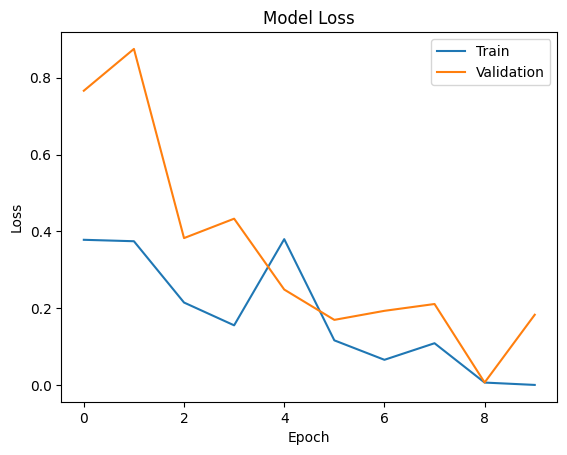

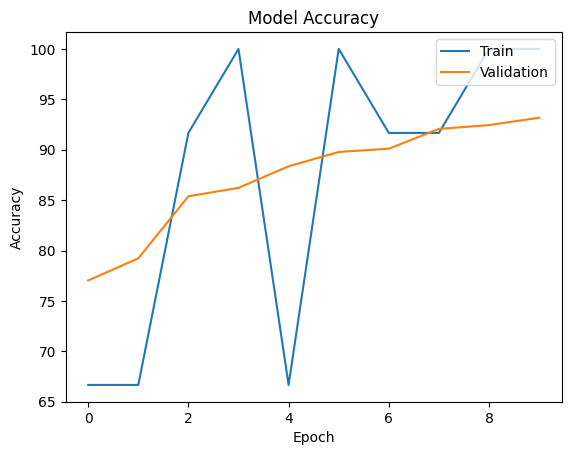

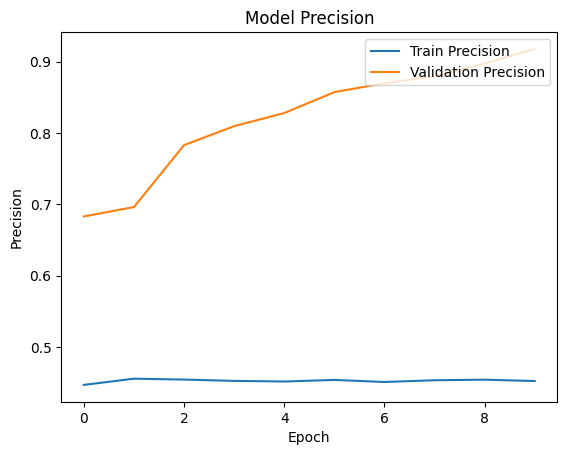

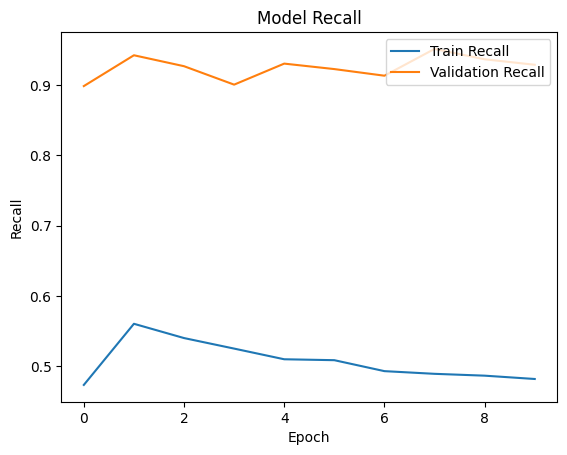

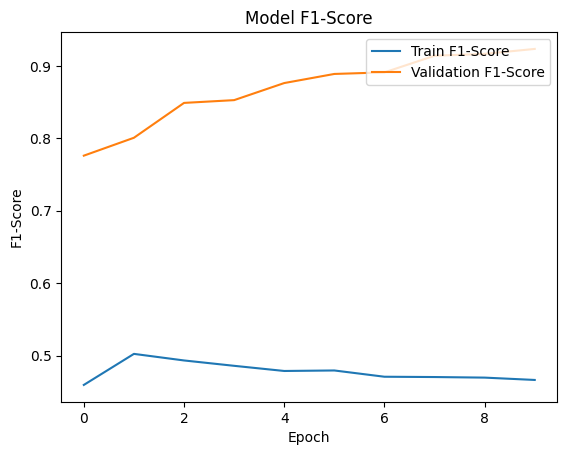

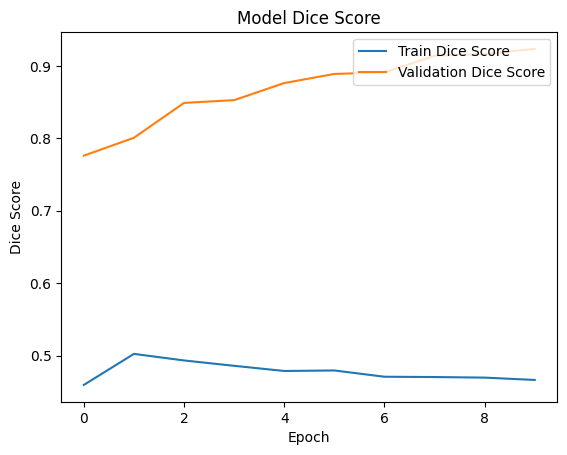

In [38]:
plot_evaluation(history, y_train_tensor, y_test_tensor)

In [46]:
# Create a new row as a DataFrame
new_row = pd.DataFrame([{
    'Model': '2 path + attention', 
    'Loss': np.mean(history['val_loss']),
    'Accuracy': np.mean(history['val_accuracy']), 
    'Dice': np.mean(history['dice_score_val']),
    'Precision': np.mean(history['precision_val']),
    'F1-Score': np.mean(history['f1_score_val']),
    'Sensitivity/Recall': np.mean(history['recall_val']),
}])

# Concatenate the new row with the existing DataFrame
Test_SCORE = pd.concat([Test_SCORE, new_row], ignore_index=True)

Test_SCORE

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_15064\3197160996.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Test_SCORE = pd.concat([Test_SCORE, new_row], ignore_index=True)


,Model,Loss,Accuracy,Dice,Precision,F1-Score,Sensitivity/Recall
0,2 path + attention,0.347061,87.377883,0.868848,0.822008,0.868848,0.925379


In [39]:
torch.save(model, 'twopathsattngates.pth')
torch.save(model.state_dict(), 'twopathsattngates_weights.pth')

In [40]:
model = torch.load('twopathsattngates.pth')
model.load_state_dict(torch.load('twopathsattngates_weights.pth'))

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_15064\571843868.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('twopathsattngates.pth')
C:

<All keys matched successfully>

# U-Net

In [32]:
import torch
import torch.nn as nn

# Define the DoubleConv module with BatchNorm and Dropout
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),  # Added BatchNorm
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),  # Added BatchNorm
            nn.Dropout(0.5)  # Added Dropout for regularization
        )

    def forward(self, x):
        return self.conv_op(x)

# Define the DownSample module
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

# Define the UpSample module with increased filters
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)  # Concatenate along the channel dimension
        return self.conv(x)

# Define the adjusted U-Net model for binary classification
class UNetBinaryClassification(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # Downsampling path
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)

        # Bottleneck
        self.bottle_neck = DoubleConv(256, 512)

        # Upsampling path
        self.up_convolution_1 = UpSample(512, 256)
        self.up_convolution_2 = UpSample(256, 128)
        self.up_convolution_3 = UpSample(128, 64)

        # Global pooling and classification layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool spatial dimensions to 1x1
        self.fc = nn.Linear(64, 1)  # Output one value for binary classification

    def forward(self, x):
        # Rearrange input from (N, H, W, C) to (N, C, H, W)
        x = x.permute(0, 3, 1, 2)  

        # Downsampling path
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)

        # Bottleneck
        b = self.bottle_neck(p3)

        # Upsampling path
        up_1 = self.up_convolution_1(b, down_3)
        up_2 = self.up_convolution_2(up_1, down_2)
        up_3 = self.up_convolution_3(up_2, down_1)

        # Global pooling
        out = self.global_pool(up_3)  # Shape: [B, 64, 1, 1]

        # Flatten to 1D tensor
        out = out.view(out.size(0), -1)  # Shape: [B, 64]

        # Fully connected layer for binary classification
        out = self.fc(out)  # Shape: [B, 1]

        # Apply sigmoid activation to get probabilities
        out = torch.sigmoid(out)  # Final output shape: [B, 1]

        return out.squeeze(1)  # Remove the singleton dimension to get shape: [B]

In [33]:
UNET = UNetBinaryClassification(in_channels=3).to(device) 

In [32]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(UNET.parameters(), lr=0.001)

In [34]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    """Calculates the Dice coefficient.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.

    Returns:
        Dice coefficient score.
    """

    #intersection = np.sum(y_true * y_pred)
    #union = np.sum(y_true) + np.sum(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + 1.) / (union + 1.)
    return dice

In [36]:
# Training loop
from torch import tensor
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score

history_UNET = {'loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 
           'f1_score': [], 'dice_score': [] ,'val_accuracy': [], 'precision_val': [], 
           'recall_val': [], 'f1_score_val': [], 'dice_score_val': [], 'y_train_prob': [], 'y_val_prob': []}

y_train_pred = []
y_val_pred = []
num_epochs = 10
for epoch in range(num_epochs):
    y_train_pred = []
    
    # Training Loop
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, labels = images.to(device), labels.to(device).float()

        # Forward pass
        outputs = UNET(images)
        loss = criterion(outputs, labels)

        # Backward and optimize   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted_probs = torch.sigmoid(outputs)
        predicted = (predicted_probs > 0.5).long()
        total = labels.size(0)
        correct = (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        y_train_pred.extend(predicted)

    # Concatenate predictions for the entire epoch
    history_UNET['y_train_prob'].append(y_train_pred)
    # Append training loss, accuracy, and predicted probabilities to history
    history_UNET['loss'].append(loss.item())
    history_UNET['accuracy'].append(train_acc)
    
    # Calculate evaluation metrics
    metric = BinaryPrecision()
    train_precision = metric(tensor(y_train_pred), y_train_tensor)
    metric = BinaryRecall()
    train_recall = metric(tensor(y_train_pred), y_train_tensor)
    metric = BinaryF1Score()
    train_f1_score = metric(tensor(y_train_pred), y_train_tensor)
    
    y_train_pred = torch.tensor(y_train_pred, dtype=torch.int64)
    train_dice_score = dice_coefficient(y_train_tensor.to(device), y_train_pred.to(device))
    print('Training Metrics Calculated')

    # Append training metrics to history
    history_UNET['precision'].append(train_precision)
    history_UNET['recall'].append(train_recall)
    history_UNET['f1_score'].append(train_f1_score)
    history_UNET['dice_score'].append(train_dice_score)

    # Evaluation on validation set
    with torch.no_grad():
        y_val_pred = []
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = UNET(images)

            predicted_probs = torch.sigmoid(outputs)
            predicted = (predicted_probs > 0.5).long()
            total = labels.size(0)
            correct = (predicted == labels).sum().item()

            y_val_pred.extend(predicted)

        # Convert list to tensor, move to CPU, then convert to numpy
        y_val_pred = torch.tensor(y_val_pred).cpu().numpy()
        history_UNET['y_val_prob'].append(y_val_pred)

        # Calculate evaluation metrics
        metric = BinaryPrecision()
        precision = metric(tensor(y_val_pred), y_test_tensor)
        metric = BinaryRecall()
        recall = metric(tensor(y_val_pred), y_test_tensor)
        metric = BinaryF1Score()
        f1_score = metric(tensor(y_val_pred), y_test_tensor)
        
        y_val_pred = torch.tensor(y_val_pred, dtype=torch.int64)
        dice_score = dice_coefficient(y_val_pred.to(device), y_test_tensor.to(device))
        
        val_acc = 100 * correct / total
        val_loss = criterion(outputs, labels).item()
        print('Validation Metrics Calculated')

        # Append validation loss, accuracy, and predicted probabilities to history
        history_UNET['val_loss'].append(val_loss)
        history_UNET['val_accuracy'].append(val_acc)
        history_UNET['precision_val'].append(precision)
        history_UNET['recall_val'].append(recall)
        history_UNET['f1_score_val'].append(f1_score)
        history_UNET['dice_score_val'].append(dice_score)

        print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f},F1-Score: {f1_score:.4f}, Dice Score: {dice_score:.4f}")


Epoch 1/10: 100%|██████████| 1377/1377 [41:52<00:00,  1.82s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 1, Validation Accuracy: 33.33%, Precision: 0.4792, Recall: 0.9967,F1-Score: 0.6472, Dice Score: 0.6473


Epoch 2/10: 100%|██████████| 1377/1377 [41:21<00:00,  1.80s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 2, Validation Accuracy: 33.33%, Precision: 0.4803, Recall: 0.9975,F1-Score: 0.6484, Dice Score: 0.6484


Epoch 3/10: 100%|██████████| 1377/1377 [43:29<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 3, Validation Accuracy: 33.33%, Precision: 0.4803, Recall: 0.9967,F1-Score: 0.6483, Dice Score: 0.6483


Epoch 4/10: 100%|██████████| 1377/1377 [43:38<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 4, Validation Accuracy: 33.33%, Precision: 0.4720, Recall: 0.9979,F1-Score: 0.6409, Dice Score: 0.6409


Epoch 5/10: 100%|██████████| 1377/1377 [43:39<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 5, Validation Accuracy: 33.33%, Precision: 0.4851, Recall: 0.9967,F1-Score: 0.6526, Dice Score: 0.6527


Epoch 6/10: 100%|██████████| 1377/1377 [43:38<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 6, Validation Accuracy: 33.33%, Precision: 0.4818, Recall: 0.9959,F1-Score: 0.6494, Dice Score: 0.6494


Epoch 7/10: 100%|██████████| 1377/1377 [43:38<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 7, Validation Accuracy: 33.33%, Precision: 0.4650, Recall: 0.9984,F1-Score: 0.6345, Dice Score: 0.6346


Epoch 8/10: 100%|██████████| 1377/1377 [43:37<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 8, Validation Accuracy: 33.33%, Precision: 0.4864, Recall: 0.9955,F1-Score: 0.6535, Dice Score: 0.6535


Epoch 9/10: 100%|██████████| 1377/1377 [43:37<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 9, Validation Accuracy: 33.33%, Precision: 0.4683, Recall: 0.9959,F1-Score: 0.6370, Dice Score: 0.6371


Epoch 10/10: 100%|██████████| 1377/1377 [43:36<00:00,  1.90s/it]


Training Metrics Calculated
Validation Metrics Calculated
Epoch 10, Validation Accuracy: 33.33%, Precision: 0.4687, Recall: 0.9959,F1-Score: 0.6374, Dice Score: 0.6375


In [37]:
from sklearn.metrics import f1_score
def plot_evaluation_UNET(history, y_true, y_test_true):
    # Plot loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'],loc='upper right')
    plt.show()

    # Plot accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'], loc='upper right')
    plt.show()

    # Precision
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['precision_val'], label='Validation Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Recall
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['recall_val'], label='Validation Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # F1-score
    plt.plot(history['f1_score'], label='Train F1-Score')
    plt.plot(history['f1_score_val'], label='Validation F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


    train_dice = history['dice_score']
    val_dice = history['dice_score_val']

    train_dice= np.array([tensor.cpu().numpy() for tensor in train_dice])
    val_dice= np.array([tensor.cpu().numpy() for tensor in val_dice])

    # Dice score
    plt.plot(train_dice, label='Train Dice Score')
    plt.plot(val_dice, label='Validation Dice Score')
    plt.title('Model Dice Score')
    plt.ylabel('Dice Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

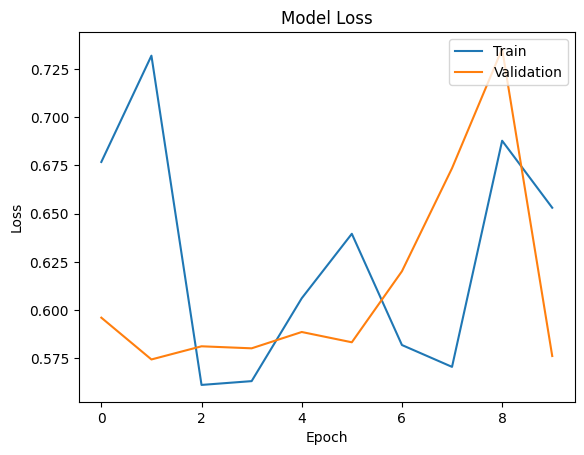

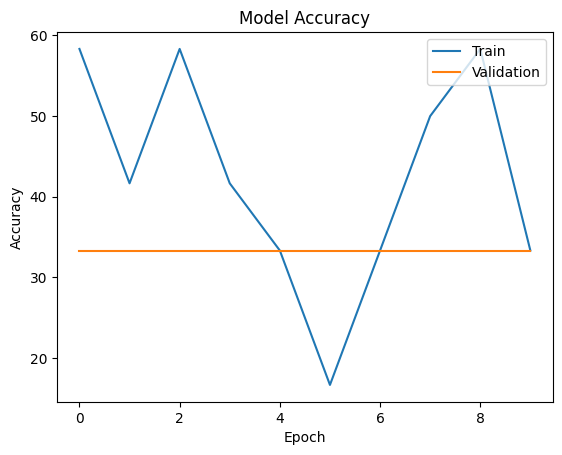

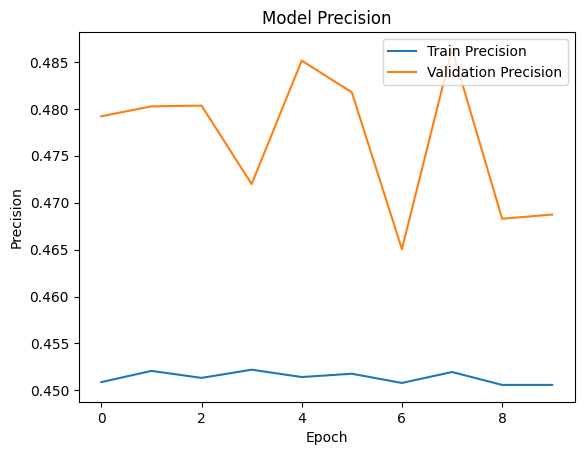

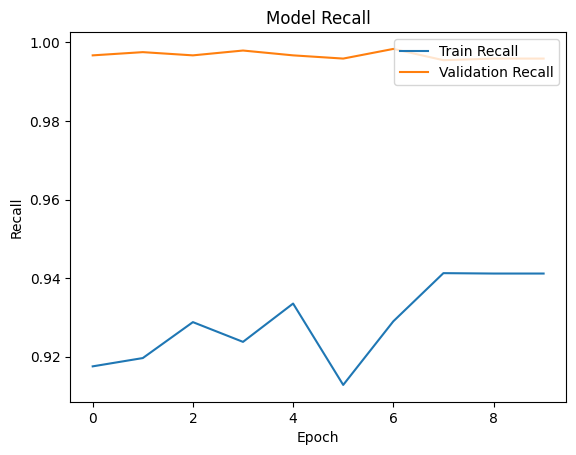

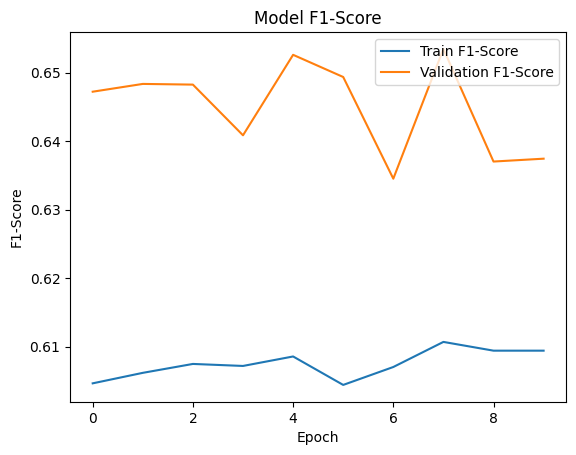

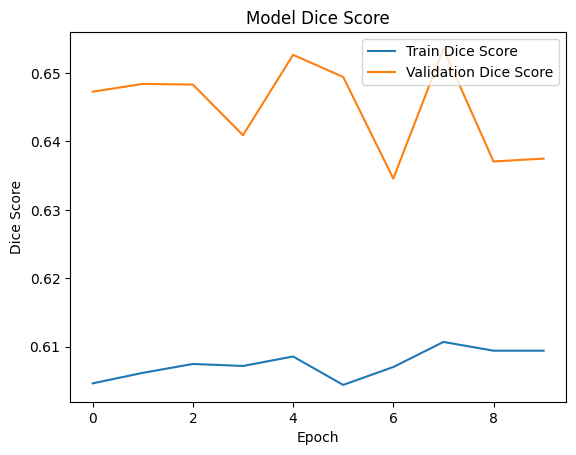

In [40]:
plot_evaluation_UNET(history_UNET,y_train_tensor,y_test_tensor)

In [43]:
val_dice = history_UNET['dice_score_val']
val_dice= np.array([tensor.cpu().numpy() for tensor in val_dice])

# Create a new row as a DataFrame
new_row = pd.DataFrame([{
    'Model': 'UNET', 
    'Loss': np.mean(history_UNET['val_loss']),
    'Accuracy': np.mean(history_UNET['val_accuracy']), 
    'Dice': np.mean(val_dice),
    'Precision': np.mean(history_UNET['precision_val']),
    'F1-Score': np.mean(history_UNET['f1_score_val']),
    'Sensitivity/Recall': np.mean(history_UNET['recall_val']),
}])

# Concatenate the new row with the existing DataFrame
Test_SCORE = pd.concat([Test_SCORE, new_row], ignore_index=True)

Test_SCORE


C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_14716\3710570786.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Test_SCORE = pd.concat([Test_SCORE, new_row], ignore_index=True)


,Model,Loss,Accuracy,Dice,Precision,F1-Score,Sensitivity/Recall
0,UNET,0.610965,33.333333,0.644968,0.476712,0.644921,0.99672


In [44]:
torch.save(UNET, 'unet.pth')
torch.save(UNET.state_dict(), 'unet_weights.pth')

In [45]:
UNET_model = torch.load('unet.pth')
UNET_model.load_state_dict(torch.load('unet_weights.pth'))

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_14716\1746708401.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  UNET_model = torch.load('unet.pth')
C:\Users\

<All keys matched successfully>

In [46]:
UNET.eval()

UNetBinaryClassification(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Dropout(p=0.5, inplace=False)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kerne

# TESTING THE MODELS

In [246]:
TWO_PATH.load_state_dict(torch.load('twopathsattngates_weights.pth'))
UNET.load_state_dict(torch.load('unet_model_WEIGHTS.pth'))

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2085849574.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TWO_PATH.load_state_dict(torch.load('twopaths

<All keys matched successfully>

In [247]:
testing = pd.DataFrame(columns=['Model','Accuracy','Prediction','Ground Truth'])
testing

,Model,Accuracy,Prediction,Ground Truth


In [248]:
import os
import h5py
import numpy as np
import re
import random

# Path to the directory containing H5 files
path = r"C:\Users\Data Science F24-MSF\Desktop\BraTS2020_training_data\content\data"  # Ensure this path is correct

# Check if the directory exists
if not os.path.exists(path):
    raise FileNotFoundError(f"The directory {path} does not exist.")

# List all H5 files in the directory
file_names = [f for f in os.listdir(path) if f.endswith('.h5')]

# Sort files based on the numbers following 'volume' and 'slice'
def extract_volume_and_slice_key(file_name):
    volume_match = re.search(r'volume_(\d+)', file_name)
    slice_match = re.search(r'slice_(\d+)', file_name)
    volume_num = int(volume_match.group(1)) if volume_match else float('inf')
    slice_num = int(slice_match.group(1)) if slice_match else float('inf')
    return volume_num, slice_num

# Sort file names by volume number first, then slice number
file_names.sort(key=extract_volume_and_slice_key)

# Preallocate list for all patients
arr_test = []

# Loop through all 369 patients, loading their corresponding 155 slices
#random_number_PAT = random.randint(11, 369)
random_number_PAT = 23
random_number_SLICE = 92
#random_number_SLICE = random.randint(15, 140)
for patient_id in range(random_number_PAT, random_number_PAT+1):  
    patient_images = []

    # Collect 155 slices for the current patient, indexed from 0 to 154
    for slice_id in range(155):  # Slices are indexed from 0 to 154
        # Construct the filename
        file_name = f"volume_{patient_id}_slice_{slice_id}.h5"
        file_path = os.path.join(path, file_name)

        # Check if the file exists
        if os.path.isfile(file_path):
            # Open the H5 file
            with h5py.File(file_path, 'r') as h5_file:
                # Print the available datasets for debugging
                #print(f"Exploring {file_name}...")
                datasets = list(h5_file.keys())  # Convert keys to a list to avoid multiple calls

                # Check if expected datasets exist
                if 'image' in datasets:  # Assuming 'image' holds the scan data
                    img_array = h5_file['image'][...]  # Load image data
                    patient_images.append(img_array)
                else:
                    print(f"Warning: 'image' dataset not found in {file_name}")
        else:
            print(f"Warning: {file_name} does not exist.")

    # Convert list of images for this patient to a 3D array
    if patient_images:
        patient_data = np.array(patient_images)
        arr_test.append(patient_data)  # Append to the main list for this patient


print(f"Loaded patient no. {random_number_PAT} with {len(arr_test[0]) if arr_test else 0} slices each.")


Loaded patient no. 23 with 155 slices each.


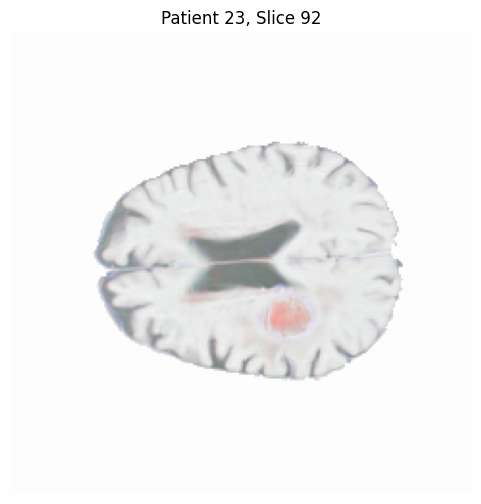

In [249]:
# Construct the file name and path for the random selection
file_name = f"volume_{random_number_PAT}_slice_{random_number_SLICE}.h5"
file_path = os.path.join(path, file_name)

# Check and load the selected image
if os.path.isfile(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        if 'image' in h5_file:
            img_array = h5_file['image'][...]  # Load the image data
        else:
            raise ValueError(f"'image' dataset not found in {file_name}")
else:
    raise FileNotFoundError(f"{file_name} does not exist.")

# Normalize the image for visualization
img_min = np.min(img_array)
img_max = np.max(img_array)
if img_max - img_min > 0:  # Avoid division by zero
    img_normalized = (img_array - img_min) / (img_max - img_min)
else:
    img_normalized = img_array  # If all values are the same, no normalization needed

# Plot the selected patient and slice
plt.figure(figsize=(6, 6))
plt.imshow(img_normalized, cmap='gray')  # Grayscale display
plt.title(f'Patient {random_number_PAT}, Slice {random_number_SLICE}')
plt.axis('off')
plt.show()


In [250]:
import pandas as pd

# Load the metadata
z = pd.read_csv(r"C:\Users\Data Science F24-MSF\Desktop\BraTS2020_training_data\content\excels\meta_data.csv")

# Print random patient and slice for debugging
print('Random Patient: ', random_number_PAT)
print('Random Slice: ', random_number_SLICE)

# Filter the DataFrame for the specific patient and slice
z_filtered = z[(z['volume'] == random_number_PAT) & (z['slice'] == random_number_SLICE)]

# Extract the 'target' value if it exists
if not z_filtered.empty:
    z = z_filtered['target'].values[0]  # Assuming you want the first matching 'target' value
    print('Target Value:', z)
else:
    print(f"No data found for Patient {random_number_PAT} and Slice {random_number_SLICE}")



Random Patient:  23
Random Slice:  92
Target Value: 1


In [251]:
# Optionally, convert to a NumPy array for further processing
arr_test = np.array(arr_test)

# Output shapes for confirmation
print(f"Total Patients: {len(arr_test)}")
print(f"Shape of first patient's images: {arr_test[0].shape if len(arr_test) > 0 else 'No data'}")

Total Patients: 1
Shape of first patient's images: (155, 240, 240, 4)


In [252]:
stripped_images=apply_stripping(arr_test)

In [253]:
df_test, y_new_test = process_image(arr_test)
print("Shape of processed images:", df_test.shape)
print("Shape of valid labels:", y_new_test.shape)
df_test=np.array(df_test)
df_test = torch.tensor(df_test, dtype=torch.float32)

No edges detected in patient 0, slice 147, channel 0. Skipping.
No edges detected in patient 0, slice 147, channel 1. Skipping.
No edges detected in patient 0, slice 147, channel 2. Skipping.
No edges detected in patient 0, slice 147, channel 3. Skipping.
No edges detected in patient 0, slice 148, channel 0. Skipping.
No edges detected in patient 0, slice 148, channel 1. Skipping.
No edges detected in patient 0, slice 148, channel 2. Skipping.
No edges detected in patient 0, slice 148, channel 3. Skipping.
No edges detected in patient 0, slice 149, channel 0. Skipping.
No edges detected in patient 0, slice 149, channel 1. Skipping.
No edges detected in patient 0, slice 149, channel 2. Skipping.
No edges detected in patient 0, slice 149, channel 3. Skipping.
No edges detected in patient 0, slice 150, channel 0. Skipping.
No edges detected in patient 0, slice 150, channel 1. Skipping.
No edges detected in patient 0, slice 150, channel 2. Skipping.
No edges detected in patient 0, slice 15

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2969183262.py:26: RuntimeWarning: invalid value encountered in divide
  input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)
C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2969183262.py:26: RuntimeWarning: invalid value encountered in cast
  input_image = (input_image / np.max(input_image) * 255).astype(np.uint8)


In [254]:
# Check if CUDA (GPU) is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming TWO_PATH is your model, move it to the correct device
TWO_PATH.to(device)

sum = 0
count = 0
for i in range(df_test.shape[0]):
    # Prepare an input image
    img = df_test[i, :, :, :]  # Load your image as a PyTorch tensor
    
    # Move image to the correct device (same as model)
    img = img.to(device)

    # Make a prediction
    with torch.no_grad():
        output = TWO_PATH(img.unsqueeze(0))  # Adding batch dimension
        _, predicted = torch.max(output.data, 1)
    
    sum += predicted.item()

    # Track correct predictions
    if predicted.item() == y_new_test[i]:
        count += 1

# Compute majority vote
majvote = sum / df_test.shape[0]
if majvote >= 0.5:
    majvote = 1
    out="the MRI scan CONTAINS a brain tumor."
else:
    majvote=0
    out="the MRI scan DOESN'T CONTAIN a brain tumor."

# Print accuracy and result
print("Accuracy is ", (count / df_test.shape[0]) * 100, '%')
print("Majority vote for the image is ", majvote, '. \nTherefore,', out)


Accuracy is  76.70068027210884 %
Majority vote for the image is  1 . 
Therefore, the MRI scan CONTAINS a brain tumor.


In [255]:
new_row = pd.DataFrame([{'Model': '2 path + attention',
                         'Accuracy': ((count / df_test.shape[0]) * 100),
                         'Prediction': majvote,
                         'Ground Truth': z}])

testing = pd.concat([testing, new_row], ignore_index=True)
testing

C:\Users\Data Science F24-MSF\AppData\Local\Temp\ipykernel_22512\2171670118.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testing = pd.concat([testing, new_row], ignore_index=True)


,Model,Accuracy,Prediction,Ground Truth
0,2 path + attention,76.70068,1,1


In [256]:
sum=0
count=0 

for i in range(df_test.shape[0]):
    # Prepare an input image
    img = df_test[i,:,:,:]  
    img=img.to(device)
    # Make a prediction
    with torch.no_grad():
        output = UNET(img.unsqueeze(0))
        predicted = torch.argmax(output)

    sum=sum+predicted.item()

    if (predicted.item()==y_new_test[i]):
        count=count+1
majvote=sum/df_test.shape[0]
if majvote>=0.5:
    majvote=1
    out="the MRI scan CONTAINS a brain tumor."
else:
    majvote=0
    out="the MRI scan DOESN'T CONTAIN a brain tumor."

print("Accuracy is ", (count/df_test.shape[0])*100, '%')
print("Majority vote for the image is ", majvote, '. \nTherefore,', out)

Accuracy is  43.53741496598639 %
Majority vote for the image is  0 . 
Therefore, the MRI scan DOESN'T CONTAIN a brain tumor.


In [257]:
new_row2 = pd.DataFrame([{'Model': 'U-Net',
                         'Accuracy': ((count / df_test.shape[0]) * 100),
                         'Prediction': majvote,
                         'Ground Truth': z}])

testing = pd.concat([testing, new_row2], ignore_index=True)
testing

,Model,Accuracy,Prediction,Ground Truth
0,2 path + attention,76.700680,1,1
1,U-Net,43.537415,0,1


# Ensemble

In [258]:
# Move the models to the same device (either CPU or GPU)
TWO_PATH.to(device)
UNET.to(device)

# Initialize variables for accuracy and majority voting
correct = 0
sum_predictions = 0

# Iterate over the test dataset
for i in range(df_test.shape[0]):
    # Prepare an input image
    img = df_test[i, :, :, :]
    
    # Move the input image to the same device as the models
    img = img.to(device)

    # Run the image through both models and average their outputs
    with torch.no_grad():
        # Get raw outputs from both models
        output1 = TWO_PATH(img.unsqueeze(0))  # Add batch dimension
        output2 = UNET(img.unsqueeze(0))     # Add batch dimension
        
        # Average the outputs
        averaged_output = (output1 + output2) / 2
    
    # Determine the predicted class from the averaged output
    predicted = torch.argmax(averaged_output).item()

    # Add to the sum for majority voting
    sum_predictions += predicted

    # Check if the prediction is correct
    if predicted == y_new_test[i]:
        correct += 1

# Compute overall accuracy
accuracy = (correct / df_test.shape[0]) * 100

# Compute majority vote
majvote = round(sum_predictions / df_test.shape[0])

# Interpret the majority vote result
if majvote == 1:
    out = "the MRI scan CONTAINS a brain tumor."
else:
    out = "the MRI scan DOESN'T CONTAIN a brain tumor."

# Print the results
print(f"Accuracy is {accuracy:.2f}%.")
print(f"Majority vote for the image is {majvote}. \nTherefore, {out}")


Accuracy is 77.72%.
Majority vote for the image is 1. 
Therefore, the MRI scan CONTAINS a brain tumor.


In [259]:
new_row3 = pd.DataFrame([{'Model': 'Ensemble',
                         'Accuracy': accuracy,
                         'Prediction': majvote,
                         'Ground Truth': z}])

testing = pd.concat([testing, new_row3], ignore_index=True)
testing

,Model,Accuracy,Prediction,Ground Truth
0,2 path + attention,76.700680,1,1
1,U-Net,43.537415,0,1
2,Ensemble,77.721088,1,1


In [260]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Move the models to the same device (either CPU or GPU)
TWO_PATH.to(device)
UNET.to(device)

# Initialize weights for data points and variables
weights = np.ones(df_test.shape[0]) / df_test.shape[0]  # Start with uniform weights
models = [TWO_PATH, UNET]
alphas = []  # Store model weights (importance in ensemble)

# AdaBoost training loop
for model in models:
    predictions = []
    
    # Iterate over the test dataset
    for i in range(df_test.shape[0]):
        img = df_test[i, :, :, :].to(device)
        with torch.no_grad():
            output = model(img.unsqueeze(0))  # Add batch dimension
            
            # Handle binary vs. multi-class outputs
            if output.shape[-1] == 1:  # Single logit (binary classification)
                probabilities = torch.sigmoid(output).cpu().numpy().flatten()
                predicted = int(probabilities[0] > 0.5)  # Convert to class label
            else:  # Multi-class output
                probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
                predicted = np.argmax(probabilities)  # Get class label
            
            predictions.append(predicted)
    
    # Compute weighted error
    predictions = np.array(predictions)
    errors = (predictions != y_new_test)
    weighted_error = np.sum(weights * errors) / np.sum(weights)
    
    # Calculate alpha (model weight)
    alpha = 0.5 * np.log((1 - weighted_error) / (weighted_error + 1e-10))
    alphas.append(alpha)
    
    # Update weights
    weights *= np.exp(-alpha * (predictions == y_new_test) + alpha * (predictions != y_new_test))
    weights /= np.sum(weights)  # Normalize weights

# Final ensemble prediction
final_predictions = np.zeros(df_test.shape[0])  # Weighted sum of probabilities
for alpha, model in zip(alphas, models):
    for i in range(df_test.shape[0]):
        img = df_test[i, :, :, :].to(device)
        with torch.no_grad():
            output = model(img.unsqueeze(0))  # Add batch dimension
            
            # Handle binary vs. multi-class outputs
            if output.shape[-1] == 1:  # Single logit (binary classification)
                probabilities = torch.sigmoid(output).cpu().numpy().flatten()
                predicted_prob = probabilities[0]  # Use probability for class 1
            else:  # Multi-class output
                probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
                predicted_prob = probabilities[1]  # Use probability for class 1
            
            final_predictions[i] += alpha * predicted_prob  # Weighted vote

# Convert final predictions to class labels (threshold at 0.5)
final_predictions = (final_predictions > 0.5).astype(int)

# Compute overall accuracy
accuracy = accuracy_score(y_new_test, final_predictions) * 100
print(f"Ensemble Accuracy with AdaBoost is {accuracy:.2f}%")


Ensemble Accuracy with AdaBoost is 74.32%


In [261]:
new_row3 = pd.DataFrame([{'Model': 'Ensemble with ADA Boost',
                         'Accuracy': accuracy,
                         'Prediction': majvote,
                         'Ground Truth': z}])

testing = pd.concat([testing, new_row3], ignore_index=True)
testing

,Model,Accuracy,Prediction,Ground Truth
0,2 path + attention,76.700680,1,1
1,U-Net,43.537415,0,1
2,Ensemble,77.721088,1,1
3,Ensemble with ADA Boost,74.319728,1,1


In [262]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Final ensemble prediction
final_predictions = np.zeros(df_test.shape[0])  # Weighted sum of probabilities
for alpha, model in zip(alphas, models):
    for i in range(df_test.shape[0]):
        img = df_test[i, :, :, :].to(device)
        with torch.no_grad():
            output = model(img.unsqueeze(0))  # Add batch dimension
            
            # Handle binary vs. multi-class outputs
            if output.shape[-1] == 1:  # Single logit (binary classification)
                probabilities = torch.sigmoid(output).cpu().numpy().flatten()
                predicted_prob = probabilities[0]  # Use probability for class 1
            else:  # Multi-class output
                probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
                predicted_prob = probabilities[1]  # Use probability for class 1
            
            final_predictions[i] += alpha * predicted_prob  # Weighted vote

# Convert final predictions to class labels (threshold at 0.5)
final_predictions = (final_predictions > 0.5).astype(int)

# Compute Dice score, Precision, and Recall
precision = precision_score(y_new_test, final_predictions)
recall = recall_score(y_new_test, final_predictions)
dice = f1_score(y_new_test, final_predictions)  # Dice score is the same as F1 score in binary classification

# Output results
accuracy = accuracy_score(y_new_test, final_predictions) * 100
print(f"Ensemble Accuracy with AdaBoost is {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Dice Score (F1): {dice:.2f}")


Ensemble Accuracy with AdaBoost is 74.15%
Precision: 0.80
Recall: 0.72
Dice Score (F1): 0.76
